# Membership Probability Calculation

The Hippacros data will be used to calculate the proper motions of stars to search for star cluster memberships.  To calcuate the candidate stars for membership probability we will take a look at using k-means method from sk-learn and DBSCAN.  To wrap things up we will summarize our findings with a 2D plot of the clusters we detected and a 3D plot of various clusters and their 

First we will filter the hippacros data using stars with low errors no less than 750pc away from our Sun.

In [1]:
import pandas as pd
import numpy as np

hip_data = pd.read_csv('hipparcos-voidmain.csv')

hip_data.head(10)

,Catalog,HIP,Proxy,RAhms,DEdms,Vmag,VarFlag,r_Vmag,RAdeg,DEdeg,...,Survey,Chart,Notes,HD,BD,CoD,CPD,(V-I)red,SpType,r_SpType
0,H,1,NaN,00 00 00.22,+01 05 20.4,9.10,NaN,H,0.000912,1.089013,...,S,NaN,NaN,224700.0,B+00 5077,NaN,NaN,0.66,F5,S
1,H,2,NaN,00 00 00.91,-19 29 55.8,9.27,NaN,G,0.003797,-19.498837,...,NaN,NaN,NaN,224690.0,B-20 6688,NaN,NaN,1.04,K3V,4
2,H,3,NaN,00 00 01.20,+38 51 33.4,6.61,NaN,G,0.005008,38.859286,...,S,NaN,NaN,224699.0,B+38 5108,NaN,NaN,0.00,B9,S
3,H,4,NaN,00 00 02.01,-51 53 36.8,8.06,NaN,H,0.008382,-51.893546,...,S,NaN,NaN,224707.0,NaN,NaN,P-52 12237,0.43,F0V,2
4,H,5,NaN,00 00 02.39,-40 35 28.4,8.55,NaN,H,0.009965,-40.591224,...,NaN,NaN,NaN,224705.0,NaN,C-41 15372,P-41 9991,0.95,G8III,2
5,H,6,NaN,00 00 04.35,+03 56 47.4,12.31,NaN,G,0.018141,3.946489,...,NaN,G,NaN,NaN,NaN,NaN,NaN,1.55,M0V:,S
6,H,7,NaN,00 00 05.41,+20 02 11.8,9.64,NaN,G,0.022549,20.036602,...,NaN,NaN,NaN,NaN,B+19 5185,NaN,NaN,0.79,G0,S
7,H,8,NaN,00 00 06.55,+25 53 11.3,9.05,3.0,H,0.027292,25.886474,...,NaN,G,P,224709.0,B+25 5054,NaN,NaN,4.82,M6e-M8.5e Tc,G
8,H,9,NaN,00 00 08.48,+36 35 09.4,8.59,NaN,H,0.035342,36.585938,...,NaN,NaN,NaN,224708.0,B+35 5149,NaN,NaN,1.00,G5,S
9,H,10,NaN,00 00 08.70,-50 52 01.5,8.59,NaN,H,0.036253,-50.867074,...,S,NaN,NaN,224717.0,NaN,C-51 13738,P-51 12065,0.51,F6V,2


## 1. Cleaning the Data

Below we select stars within 750pc of the Sun with less than 20% error in their measurements in our cleaning function

In [2]:
def cleaner(df):
    
    valid_mask = (
        (df['Plx'] > 0) &
        (df['e_Plx'] / df['Plx'] < 0.2) &
        (df['Plx'].notnull()) & 
        (df['e_RAdeg'] / df['RAdeg'] < 0.2 ) &
        (df['RAdeg'].notnull()) &
        (df['e_DEdeg'] / df['DEdeg'] < 0.2 ) &
        (df['DEdeg'].notnull()) &
        (df['e_pmRA'] / df['pmRA'] < 0.2 ) &
        (df['pmRA'].notnull()) &
        (df['e_pmDE'] / df['pmDE'] < 0.2 ) &
        (df['pmDE'].notnull()) 
    )
    
    df = df[valid_mask].copy()
    
    # calculate distance in parsecs
    df['distance'] = 1000.0 / df['Plx']
    
    df = df[df['distance'] < 750.0]
    
    return df

hipp_cleaned = cleaner(hip_data)

## 2. Using K-Means Probability 

K-means from sklearn.cluster partitions the data into k clusters by minimizing the distance from each point to its cluster center.  A guess for the number of clusters needs to be initiliazed. 

In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_stars_kmeans(df, n):

    features = df[['RAdeg', 'DEdeg', 'pmRA', 'pmDE']].dropna()
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=n, random_state=15, n_init='auto')
    
    labels = kmeans.fit_predict(scaled_features)
    df_result = df.loc[features.index].copy()
    df_result['kmeans_label'] = labels
    
    return df_result

# filter subset to make cluster searching more efficient
# k-means struggled with a full search
subset = hipp_cleaned[
    (hipp_cleaned['RAdeg'] > 50) & (hipp_cleaned['RAdeg'] < 200) &
    (hipp_cleaned['DEdeg'] > 10) & (hipp_cleaned['DEdeg'] < 40)
    ]

print(cluster_stars_kmeans(subset), 20)

      Catalog    HIP Proxy        RAhms        DEdms  Vmag  VarFlag r_Vmag  \
15534       H  15549   NaN  03 20 20.37  +29 02 54.6  4.47      1.0      G   
15542       H  15557   NaN  03 20 25.57  +25 39 46.7  6.14      NaN      H   
15550       H  15565   NaN  03 20 33.63  +12 20 47.6  7.34      NaN      G   
15561       H  15576   NaN  03 20 39.66  +28 49 36.0  8.43      NaN      H   
15571       H  15586   NaN  03 20 45.72  +23 11 02.4  8.48      NaN      G   
...       ...    ...   ...          ...          ...   ...      ...    ...   
64961       H  65018   NaN  13 19 42.30  +23 03 40.1  9.60      NaN      H   
64962       H  65019   NaN  13 19 42.70  +36 04 58.3  7.20      NaN      H   
64972       H  65028   NaN  13 19 47.30  +36 22 25.8  7.65      NaN      H   
64982       H  65039   NaN  13 19 53.66  +28 06 16.9  8.27      NaN      H   
64985       H  65042   NaN  13 19 56.64  +38 22 08.4  8.34      NaN      H   

            RAdeg      DEdeg  ... Notes        HD         BD  C

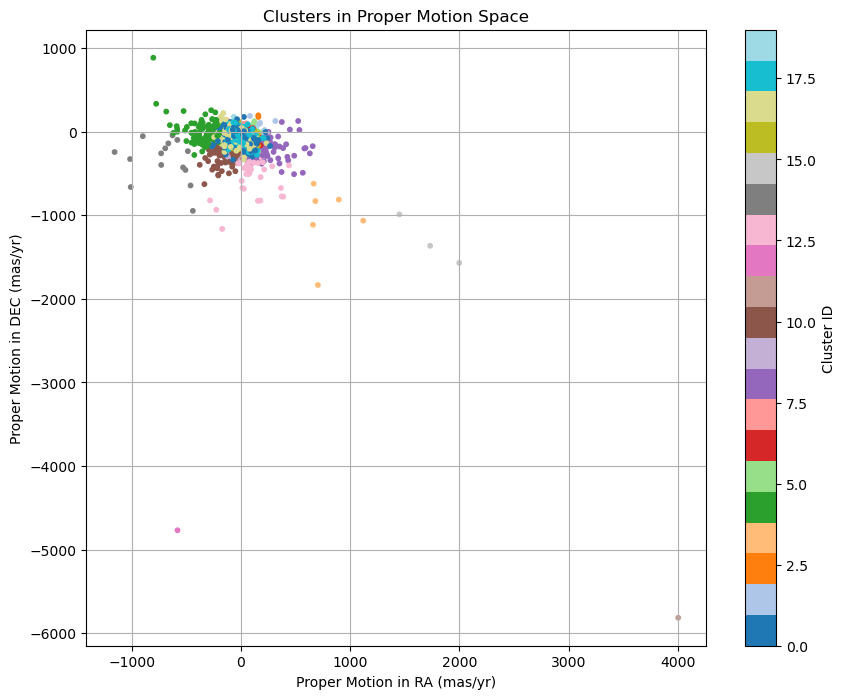

In [13]:
import matplotlib.pyplot as plt

def plot_cluster(df):
    
    plt.figure(figsize=(10,8))
    plt.scatter(df['pmRA'], df['pmDE'], c = df['kmeans_label'], cmap = 'tab20', s = 10)
    
    plt.xlabel('Proper Motion in RA (mas/yr)')
    plt.ylabel('Proper Motion in DEC (mas/yr)')
    plt.title('Clusters in Proper Motion Space')
    
    plt.colorbar(label='Cluster ID')
    plt.grid(True)
    
    plt.show()

plot_cluster(cluster_stars_kmeans(subset), 20)

We can see its working but we need to zoom in to see the activity.  Let's filter our dataframe a bit more to zoom in on the region

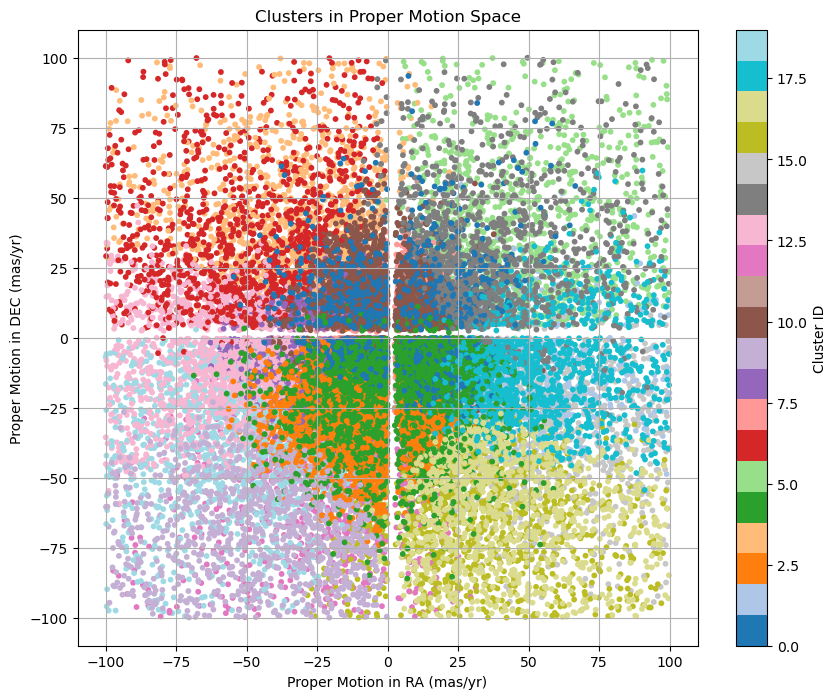

In [15]:
central_blob = hipp_cleaned[
    (hipp_cleaned['pmRA'] > -100) & (hipp_cleaned['pmRA'] < 100) &
    (hipp_cleaned['pmDE'] > -100) & (hipp_cleaned['pmDE'] < 100)
]

plot_cluster(cluster_stars_kmeans(central_blob))

We can separate the populations in subplots of RA vs DEC so we can see the individual members in tight groups

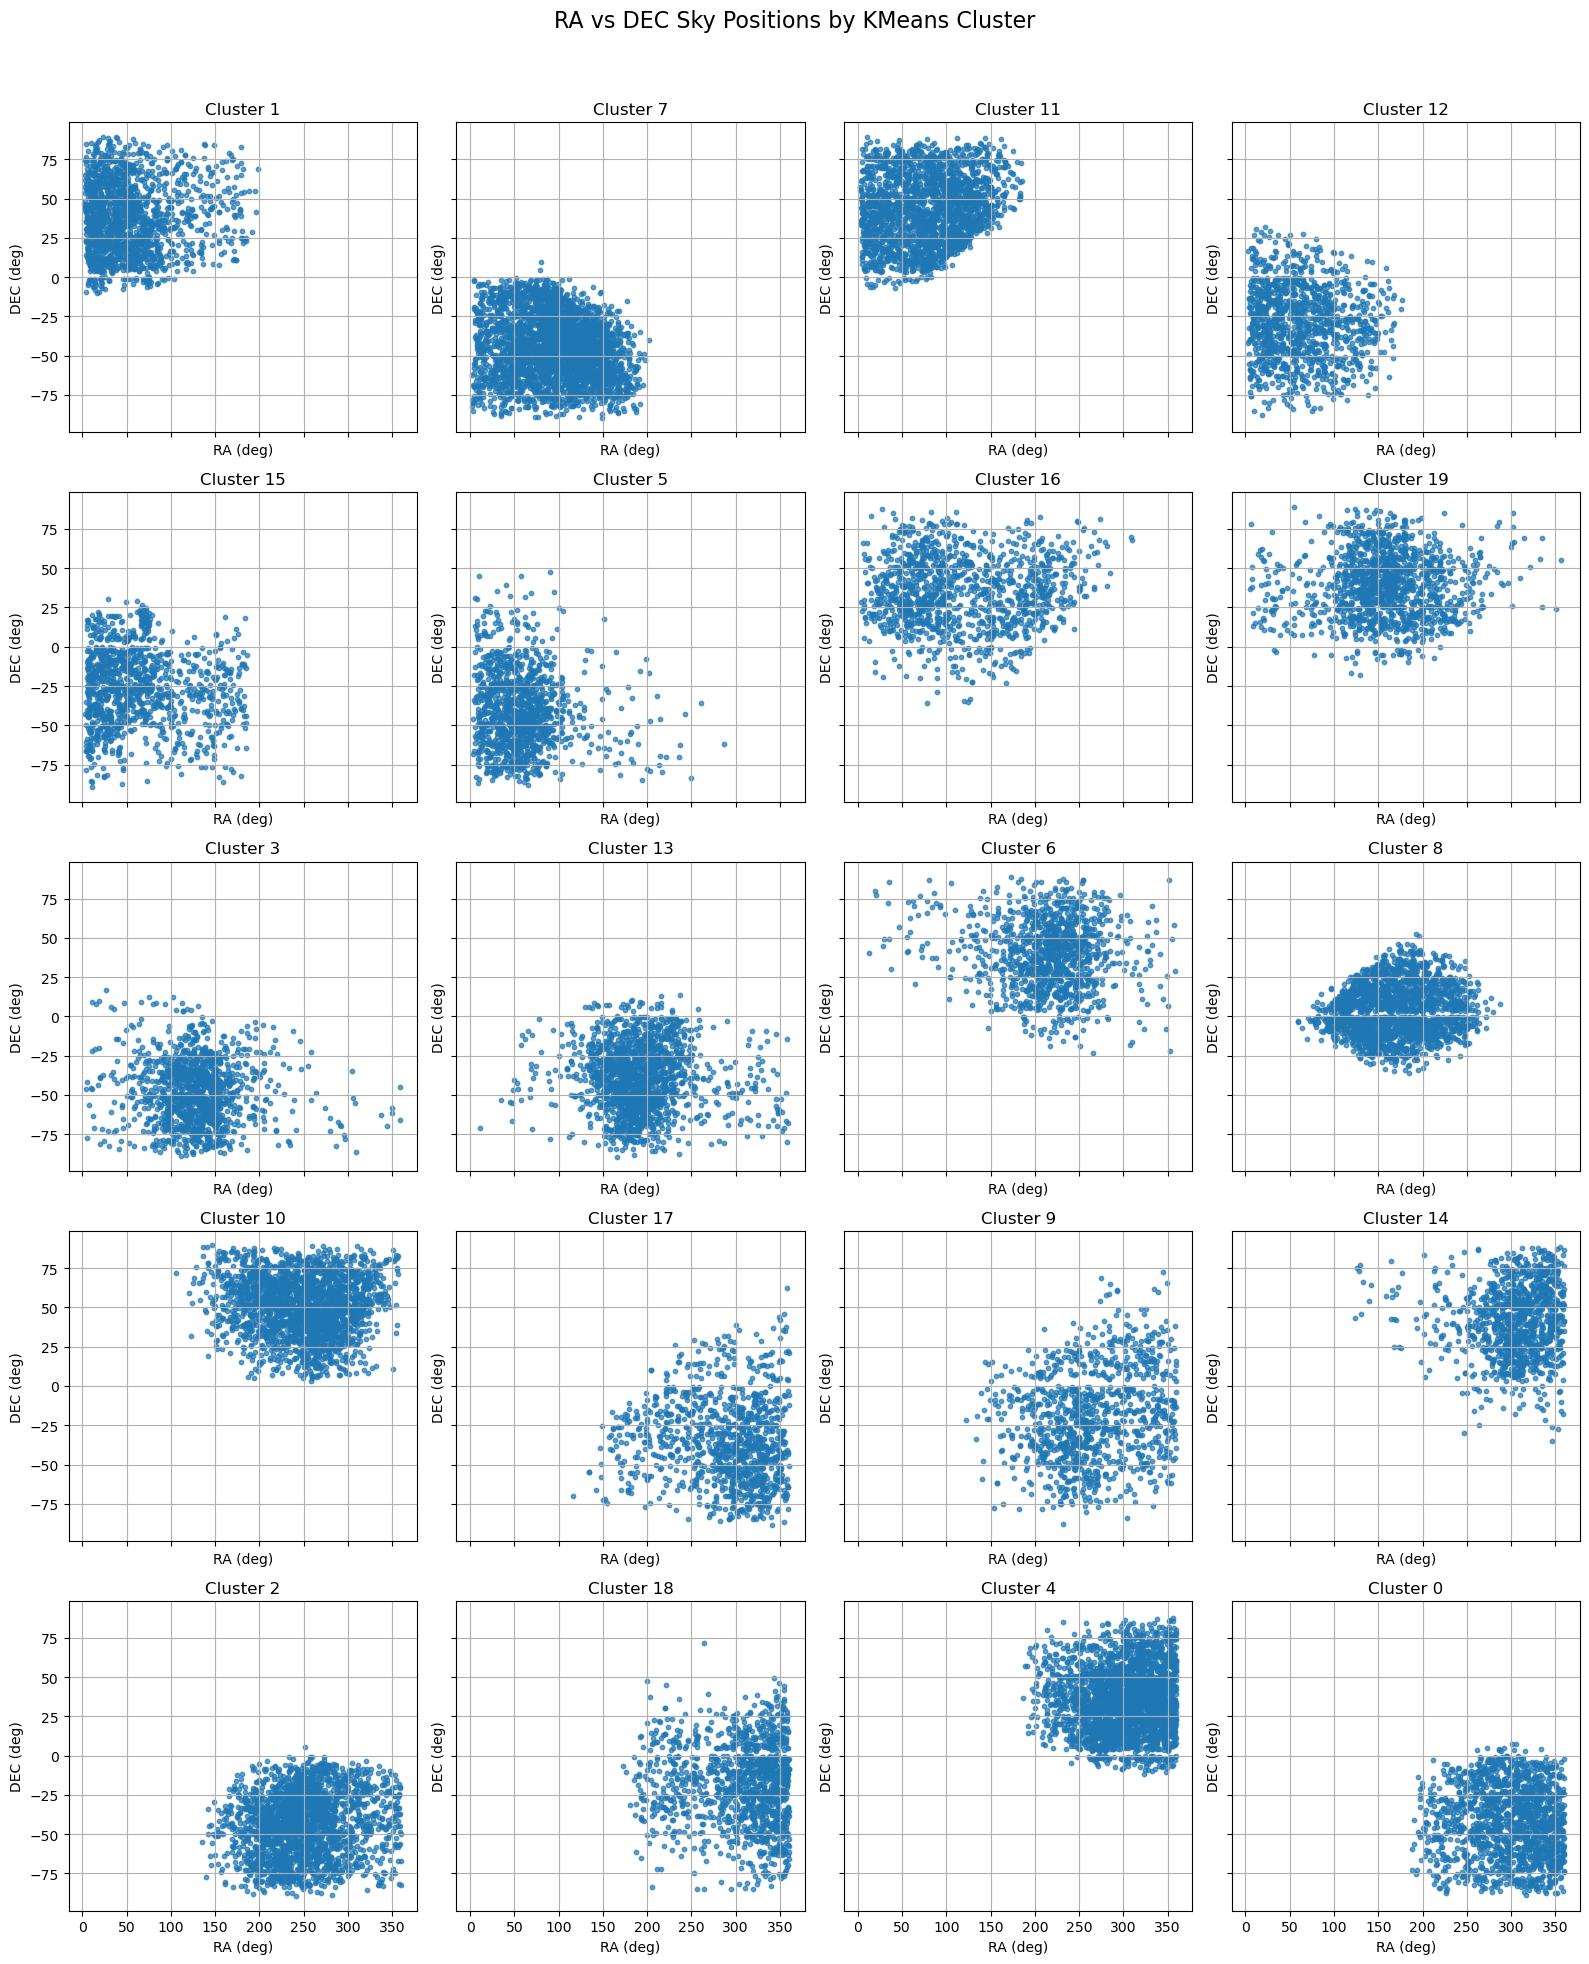

In [16]:
def plot_clusters_on_sky_subplots(df, cluster_col='kmeans_label', ra_col='RAdeg', dec_col='DEdeg'):
    cluster_ids = df[cluster_col].dropna().unique()
    n_clusters = len(cluster_ids)
    n_cols = 4
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for idx, cluster_id in enumerate(cluster_ids):
        cluster_df = df[df[cluster_col] == cluster_id]
        ax = axes[idx]
        ax.scatter(cluster_df[ra_col], cluster_df[dec_col], s=10, alpha=0.7)
        ax.set_title(f'Cluster {int(cluster_id)}')
        ax.set_xlabel('RA (deg)')
        ax.set_ylabel('DEC (deg)')
        ax.grid(True)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle('RA vs DEC Sky Positions by KMeans Cluster', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
plot_clusters_on_sky_subplots(cluster_stars_kmeans(central_blob, 20))

Given that these are star groupings with very large ranges of right ascension and declination, we can say that these are groups of stars moving together in the disk of the galaxy.  We will zoom into a much smaller patch of sky and search for more tightly knit clusters.  We will put in the patch of sky that containes the Hyades Cluster.  Since we know we are looking for one cluster we will lower n to 3

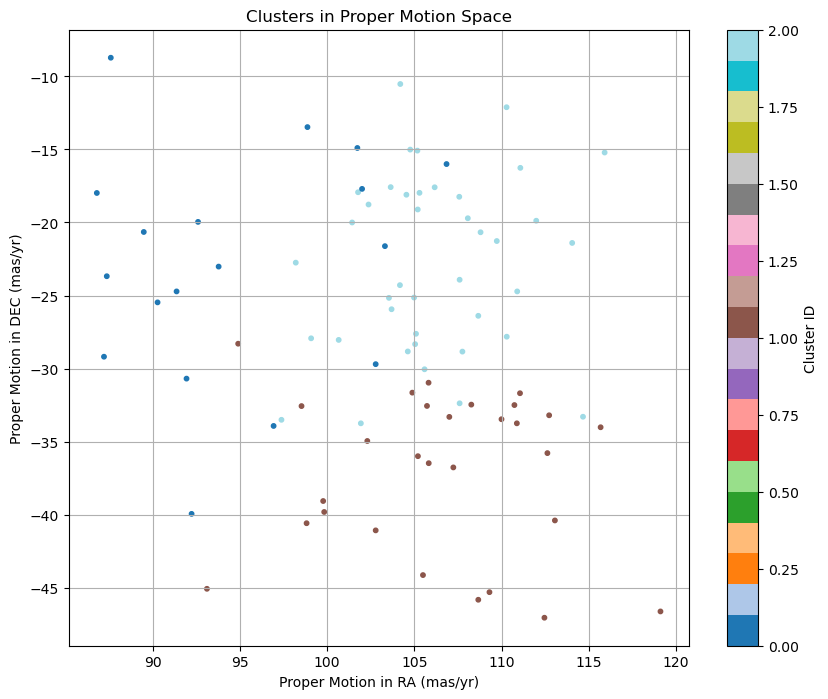

In [32]:
# hyades pm center values
pmra_center = 104  # mas/yr
pmdec_center = -28 # mas/yr

tolerance = 20  # tighten as needed

hyades_patch = hipp_cleaned[
    (hipp_cleaned['RAdeg'] >= 65) & (hipp_cleaned['RAdeg'] <= 75) &
    (hipp_cleaned['DEdeg'] >= 10) & (hipp_cleaned['DEdeg'] <= 25) & 
    (np.abs(hipp_cleaned['pmRA'] - pmra_center) < tolerance) &
    (np.abs(hipp_cleaned['pmDE'] - pmdec_center) < tolerance)
    ]

plot_cluster(cluster_stars_kmeans(hyades_patch, 3))

And subplots for the kmeans groupings

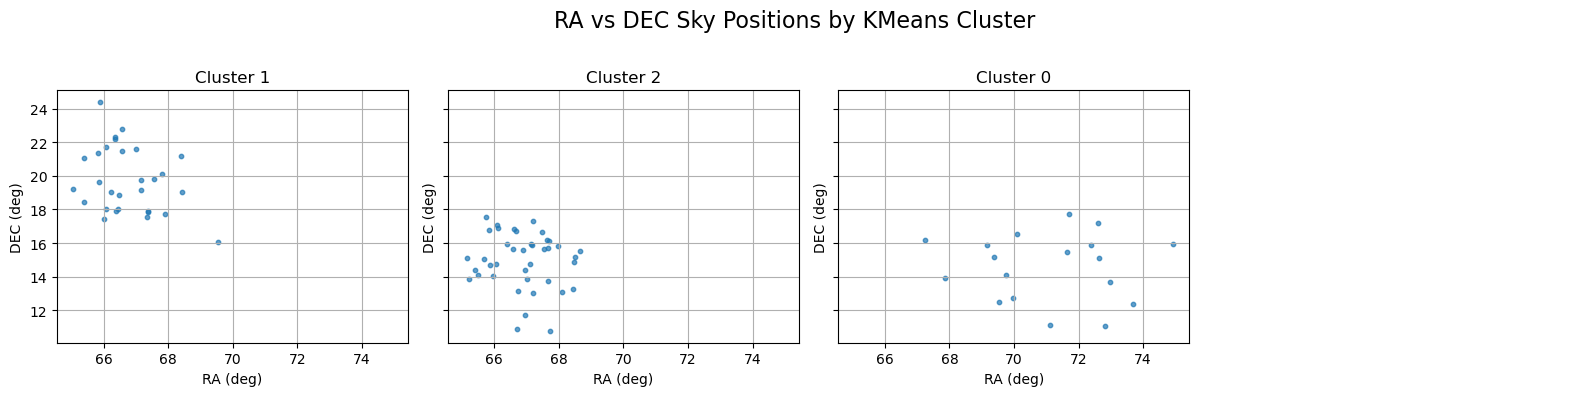

In [33]:
plot_clusters_on_sky_subplots(cluster_stars_kmeans(hyades_patch, 3))

While KMeans clustering offers a straightforward and computationally efficient method to segment stars based on their spatial and kinematic properties, it fundamentally assumes spherical clusters of similar size and requires the number of clusters to be set in advance (n_clusters). This makes it less suited for detecting true open star clusters, which often:

Vary in density and shape

Exist within dense backgrounds of field stars

May not stand out as obvious partitions in RA, DEC, or proper motion space

In our Hipparcos-based analysis, KMeans was able to group stars with similar positions and motions, and some subclusters hinted at meaningful groupings. However, even in sky patches containing known clusters (e.g. the Hyades or Pleiades), the method split physically associated stars into multiple artificial clusters or diluted them with field stars. This reflects the limitation of centroid-based clustering in astrophysical contexts, where:

True cluster boundaries are fuzzy

Outliers and varying densities are common

Spatial and kinematic correlation is non-Euclidean and anisotropic


We are now going to switch to DBSCAN, in order to greatly improve our results

## 3. Using DBSCAN

DBSCAN is a clustering algorithm that groups points based on how densely packed they are in space. Instead of assuming the number of clusters like k-means does, DBSCAN lets the data tell you how many clusters there are.  It works very well with detecting noise, and uses three classifications: core, border, noise. 

DBSCAN is great for star clusters because it doesn't need you to guess the number of clusters, it does well with clusters that aren't shaped like spheres, and its good with higher dimensions.  We will be working in a 4D space (RA, DEC, DECpm, RApm).

Here is our DBSCAN function below.  We set the minimum required distance to be at 0.5 units with 5 for the minimum number of stars required to consider somewhere to be a dense star region


In [50]:
from sklearn.cluster import DBSCAN

def cluster_stars_dbscan(df, eps=0.3, min_samples=5):

    features = df[['pmRA', 'pmDE', 'distance']].dropna()

    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Run DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_features)

    # Create result DataFrame
    df_result = df.loc[features.index].copy()
    df_result['dbscan_label'] = labels

    return df_result

DBSCAN = cluster_stars_dbscan(hipp_cleaned)

We have a lot of clusters and associations discovered with our fine-tuned parameters, but lets make sure the one with the largest populations of stars

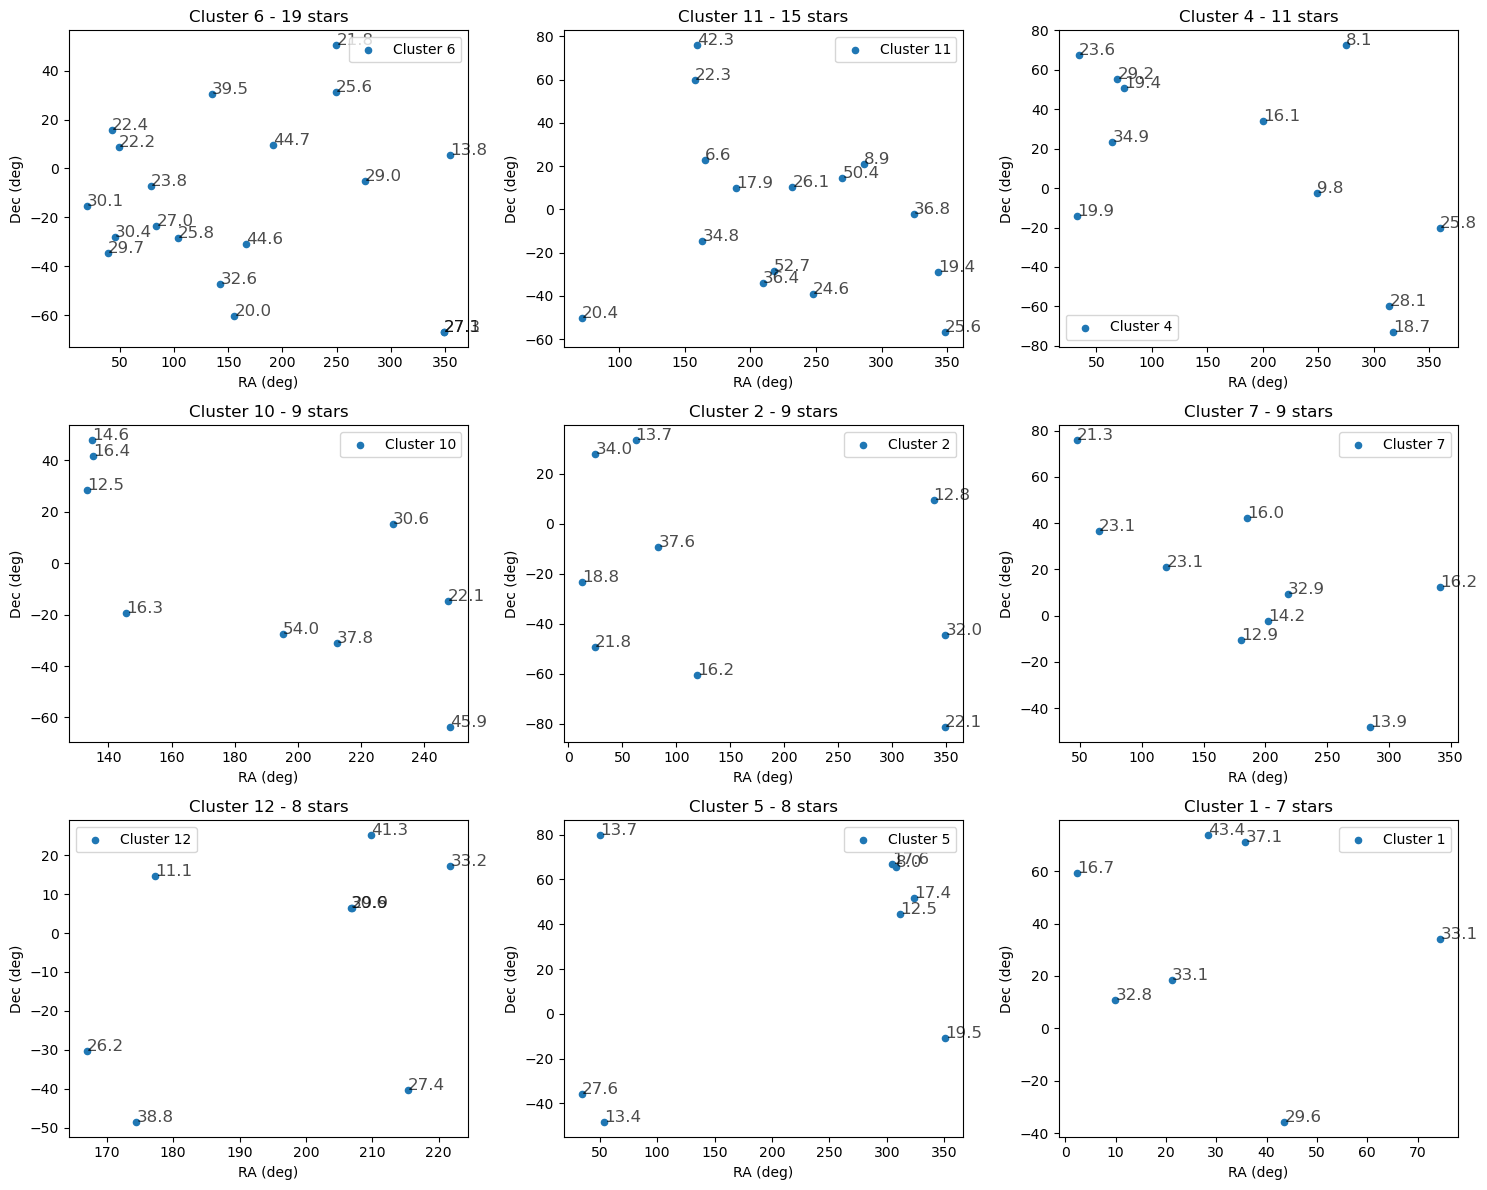

In [51]:
def plot_top_clusters(df, label_column='dbscan_label'):
    
    # Exclude noise (-1) and background cluster (0)
    cluster_counts = df[df[label_column] > 0][label_column].value_counts().head(9)
    top_labels = cluster_counts.index

    fig, axs = plt.subplots(3, 3, figsize=(15, 12))
    
    axs = axs.flatten()

    for ax, label in zip(axs, top_labels):
        cluster_df = df[df[label_column] == label]
        ax.scatter(cluster_df['RAdeg'], cluster_df['DEdeg'], label=f'Cluster {label}', s=20)
        
        for _, row in cluster_df.iterrows():
            distance_pc = round(1000.0 / row['Plx'], 1) if row['Plx'] > 0 else "NaN"
            ax.annotate(f"{distance_pc}", (row['RAdeg'], row['DEdeg']), fontsize=12, alpha=0.7)
        
        ax.set_title(f'Cluster {label} - {len(cluster_df)} stars')
        ax.set_xlabel('RA (deg)')
        ax.set_ylabel('Dec (deg)')
        ax.legend()

    plt.tight_layout()
    plt.show()

# Run the function using real data
plot_top_clusters(DBSCAN)


We are going to cross reference the centers of these populations with known clusters.  We will fetch the RA and DEC average for the cluster members and identify any clusters we can find

In [57]:
def get_cluster_centers(df, label_col='dbscan_label', ra_col='RAdeg', dec_col='DEdeg'):
    
    filtered = df[(df[label_col] > 0)]  # skip noise (-1) and background (0)
    cluster_centers = (
        filtered.groupby(label_col)[[ra_col, dec_col]]
        .mean()
        .reset_index()
        .rename(columns={label_col: 'Cluster ID', ra_col: 'Mean RA', dec_col: 'Mean DEC'})
    )
    return cluster_centers


Now we knock on Vizier's door and pull some data from clusters and associations we know of

In [59]:
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u
import warnings
from astropy.units import UnitsWarning

def cross_reference_top_clusters(df, label_column='dbscan_label', top_n=20, radius_deg=1.0):

    warnings.simplefilter('ignore', category=UnitsWarning)

    # Get top clusters excluding noise (-1) and label 0
    cluster_counts = df[label_column].value_counts()
    cluster_labels = cluster_counts.drop(labels=[-1, 0], errors='ignore').head(top_n).index

    # Prepare Vizier
    Vizier.ROW_LIMIT = 50
    Vizier.columns = ['*']

    results = {}
    for label in cluster_labels:
        cluster_df = df[df[label_column] == label]
        ra_mean = cluster_df['RAdeg'].mean()
        dec_mean = cluster_df['DEdeg'].mean()
        coord = SkyCoord(ra=ra_mean * u.deg, dec=dec_mean * u.deg)

        try:
            result = Vizier.query_region(coord, radius=radius_deg * u.deg, catalog='J/A+A/389/871')
            results[label] = result[0] if result else None
        except Exception as e:
            print(f"Error querying label {label}: {e}")
            results[label] = None

    return results


# Cross-reference top clusters (excluding 0 and -1)
cluster_matches = cross_reference_top_clusters(DBSCAN)

# Print summary of matches
for label, table in cluster_matches.items():
    print(f"\nCluster Label: {label}")
    
    if table is not None and len(table) > 0:
        print(f"Available columns: {table.colnames}")
        
        # Try to show common useful columns if they exist
        preferred_cols = ['Name', 'Cluster', 'Cl', 'RAJ2000', 'DEJ2000', 'r0']
        cols_to_show = [col for col in preferred_cols if col in table.colnames]
        
        if cols_to_show:
            print(table[cols_to_show])
        else:
            print(table)  # fallback if preferred columns are missing
    else:
        print("No matching cluster found.")


Cluster Label: 6
Available columns: ['Seq', 'Name', 'Source', 'Ncomp', 'Ncomb', 'Comps', 'RA_ICRS', 'DE_ICRS', 'SertABCD', 'Class', 'Known', 'BibCode', 'Scomb']
            Name           
---------------------------
DR3Gaia104543.268-140721.72
DR3Gaia104739.076-134834.65
DR3Gaia104928.318-133130.67
DR3Gaia104617.109-140227.56
DR3Gaia104703.858-140748.84
DR3Gaia104911.061-143955.10
DR3Gaia105050.798-134523.48
DR3Gaia104612.421-135049.96

Cluster Label: 11
Available columns: ['ID', 'RAJ2000', 'DEJ2000', 'zspec', 'Nmem', 'N200', 'sigmaCl', 'e_sigmaCl', 'R200', 'e_R200', 'M200', 'e_M200', 'Lx', 'Mx', 'SimbadName']
 RAJ2000    DEJ2000  
   deg        deg    
---------- ----------
226.027154  -2.807894

Cluster Label: 4
Available columns: ['2FGL', 'RAJ2000', 'DEJ2000', 'logF', 'alpha', 'RMag', 'z', 'u_z', 'n_z', 'zmin', 'zmax', 'Type', 'SED', 'Tel', 'MJD', 'Simbad', 'NED']
 RAJ2000    DEJ2000  
   deg        deg    
---------- ----------
181.050729  11.765358

Cluster Label: 7
Available co

In this project, applied unsupervised clustering methods to the Hipparcos catalog to detect potential open star clusters based on spatial proximity (RA, Dec), proper motion (pmRA, pmDE), and distance (via parallax).

After initial trials with K-Means, I transitioned to DBSCAN, which proved to be a more appropriate tool for this kind of astronomical clustering.  K-Means assumes clusters are convex and isotropic in Euclidean space, which doesn't hold for astrophysical data that may have irregular shapes and densities. It also requires a preset number of clusters (k), which is not practical when the true number of clusters is unknown or variable.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) does not require the number of clusters to be specified, and it can identify clusters of arbitrary shape while filtering out noise (unclustered stars) naturally. This made it better suited for detecting real stellar associations amid the field star population.  Using the centroids of the DBSCAN-detected clusters, I queried multiple star catalogs in Vizier, including open cluster catalogs and Gaia DR3 databases. The results included significant overlaps between DBSCAN-detected groups and known Gaia stars, suggesting many clusters may correspond to real associations.

Several DBSCAN labels (e.g., clusters 1, 4, 6, 12, 14, 16) contained multiple high-confidence Gaia matches, strengthening the case for their astrophysical validity.  DBSCAN was critical for revealing subtle, non-spherical groupings in proper motion–distance–position space, which K-Means often fragmented or missed.  The cross-referencing step validated many of the detected clusters and provides a pathway for confirming new cluster candidates or rediscovering known ones from historical data.
